In [1]:
%cd ScrabbleGAN

/home/aanadvikova/ScrabbleGAN


In [2]:
from config import Config
import pickle as pkl
from generate_images import ImgGenerator
import matplotlib.pyplot as plt
import torch
import numpy as np

In [3]:
config=Config

In [4]:
with open('/home/aanadvikova/ScrabbleGAN/data/RIMES_tr_data.pkl', 'rb') as f:
   char_map = pkl.load(f)

In [5]:
char_map=char_map['char_map']

In [6]:
generator = ImgGenerator(checkpt_path='/home/aanadvikova/ScrabbleGAN/weights/model_checkpoint_epoch_200.pth.tar',
                         config=config, char_map=char_map)

Model: ScrabbleGAN
Param count for Gs initialized parameters: 30869377
Param count for Ds initialized parameters: 36398401


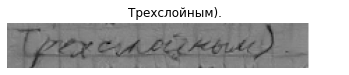

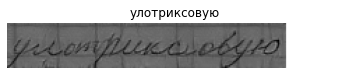

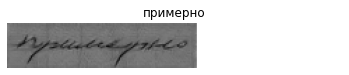

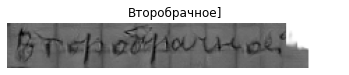

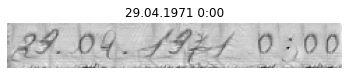

In [28]:
num_imgs = 5
generated_imgs, _, word_labels = generator.generate(random_num_imgs=num_imgs)
for label, img in zip(word_labels, generated_imgs):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)
    plt.show()

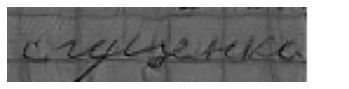

In [23]:
sentences = [['сгущенка']]

for word_list in sentences:
    generated_imgs, _, word_labels = generator.generate(word_list=word_list)
    sentence_img = []
    for label, img in zip(word_labels, generated_imgs):
        img = img[:, img.sum(0) < 31.5]
        sentence_img.append(img)
        sentence_img.append(np.ones((img.shape[0], 15)))
    sentence_img = np.hstack(sentence_img)
    plt.imshow(sentence_img, cmap='gray')
    plt.axis('off')
    plt.show()

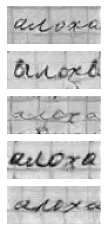

In [43]:
z_dist = torch.distributions.Normal(loc=0, scale=1.)


noise_seed = 51

torch.manual_seed(noise_seed)
z = z_dist.sample([128])

word = 'алоха'
num_samples = 5
generated_imgs, _, word_labels = generator.generate(word_list=[word] * num_samples, z=z)
columns = 1
rows = num_samples
fig=plt.figure()
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(generated_imgs[i-1], cmap='gray')
plt.show()

In [9]:
%cd ..

/home/aanadvikova


In [10]:
import pandas as pd

In [44]:
df = pd.read_csv('/home/aanadvikova/ScrabbleGAN/data/RIMES/ground_truth_validation_icdar2011.tsv', sep = '\t', header = None)

In [11]:
df = pd.read_csv('/home/aanadvikova/ScrabbleGAN/data/RIMES/ground_truth_training_icdar2011.tsv', sep = '\t', header = None)

In [45]:
df.columns = ['image', 'label']
df

,image,label
0,test0.png,ибо
1,test1.png,осталось
2,test10.png,поле
3,test100.png,Оптическое
4,test1000.png,1 класса
...,...,...
1539,testtt658.png,г. Иркутска
1540,testtt659.png,"Андреевна,"
1541,testtt677.png,Юрьевна
1542,testtt692.png,девяносто)


In [46]:
df=df.dropna(subset=['label'])
df

,image,label
0,test0.png,ибо
1,test1.png,осталось
2,test10.png,поле
3,test100.png,Оптическое
4,test1000.png,1 класса
...,...,...
1539,testtt658.png,г. Иркутска
1540,testtt659.png,"Андреевна,"
1541,testtt677.png,Юрьевна
1542,testtt692.png,девяносто)


In [47]:
from PIL import Image
import tqdm

In [48]:
!rm -r cyr_val
!mkdir cyr_val

In [49]:
for i, row in tqdm.tqdm(df.iterrows()):

      word_list = str(row.label).replace(' ', '')
      generated_imgs, _, word_labels = generator.generate(word_list=[word_list])
      sentence_img = []
      for label, img in zip(word_labels, generated_imgs):
          img = img[:, img.sum(0) < 31.5]
          sentence_img.append(img)
          sentence_img.append(np.ones((img.shape[0], 15)))
      sentence_img = (sentence_img[0])
      plt.imsave('/home/aanadvikova/cyr_val/' + row.image, sentence_img, cmap='gray')


1544it [00:26, 57.35it/s]


In [50]:
import glob

In [55]:
#!rm -r temp_real
#!mkdir temp_real

real_path = 'temp_real'

images_real = glob.glob('/home/aanadvikova/ScrabbleGAN/data/RIMES/validation/*')

for idx, img in enumerate(tqdm.tqdm(images_real)):
  img = Image.open(img).convert("RGB").convert('L')
  img = img.resize((512,128))
  img.save(f'{real_path}/{idx}.png')

100%|██████████| 1544/1544 [01:00<00:00, 25.61it/s]


In [56]:
!pip install pytorch_fid

Defaulting to user installation because normal site-packages is not writeable


In [57]:
!rm -r temp_fake
!mkdir temp_fake

images_fake = glob.glob('/home/aanadvikova/cyr_val/*')
fake_path = 'temp_fake'

for idx, img in enumerate(tqdm.tqdm(images_fake)):
  img = Image.open(img).convert("RGB").convert('L')
  img = img.resize((512,128))
  img.save(f'{fake_path}/{idx}.png')

100%|██████████| 1544/1544 [00:30<00:00, 49.98it/s]


In [58]:
!python -m pytorch_fid 'temp_real' 'temp_fake'

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/aanadvikova/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:02<00:00, 42.1MB/s]
100%|███████████████████████████████████████████| 31/31 [00:04<00:00,  7.47it/s]
FID:  135.55411212276
